In [14]:
# Drive Mount
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

# Check path
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/MyDrive


In [2]:
import os
import glob
import torch
import torchaudio
import torchaudio.transforms as T
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [3]:
# Check number of wav files
train_healthy_paths = list(glob.glob('./SVD/train/healthy/*.wav'))
train_pathology_paths = list(glob.glob('./SVD/train/pathology/*.wav'))
test_healthy_paths = list(glob.glob('./SVD/test/healthy/*.wav'))
test_pathology_paths = list(glob.glob('./SVD/test/pathology/*.wav'))
print(f'train healthy   : {len(train_healthy_paths)} audios')
print(f'train_pathology : {len(train_pathology_paths)} audios')
print(f'test_healthy    : {len(test_healthy_paths)} audios')
print(f'test_pathology  : {len(test_pathology_paths)} audios')

train healthy   : 532 audios
train_pathology : 762 audios
test_healthy    : 100 audios
test_pathology  : 100 audios


In [4]:
# healthy example
path = train_healthy_paths[0] # take a healthy sample.
print(path)
waveform, sample_rate = torchaudio.load(path)
print(sample_rate)

./SVD/train/healthy/40-phrase.wav
50000


In [5]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    #ax.set_ylabel(ylabel) # don't need ylabel to train/test image
    plt.axis('off')
    plt.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


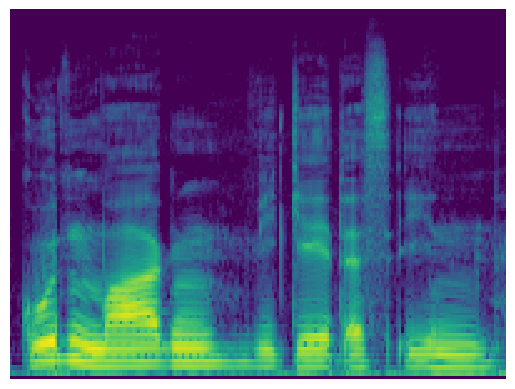

In [6]:
# vars for mel_spectrogram
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

# create mel_spectrogram class object
mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

# 1 sample opreration test
melspec = mel_spectrogram(waveform) # create melspec instance
plot_spectrogram(melspec[0]) # instance plotting

In [7]:
def load_audios(paths):
    paths = paths
    dataset = []
    for p in paths:
        name = os.path.basename(p) # extract file names at each path.
        name = os.path.splitext(name)[0] # remove extensions so left only file names.
        waveform, sample_rate = torchaudio.load(p)  # get meta data,
        dataset.append([waveform, sample_rate, name]) # append meta data on list.
    return dataset

h_train = load_audios(train_healthy_paths)
p_train = load_audios(train_pathology_paths)
h_test = load_audios(test_healthy_paths)
p_test = load_audios(test_pathology_paths)

In [8]:
num_workers = 2

In [9]:
# create loader objects.
# test sets don't have to shuffle
# num_workers are best on 2~4
loader_h_train = DataLoader(h_train, batch_size=1, shuffle=False, num_workers=num_workers)
loader_p_train = DataLoader(p_train, batch_size=1, shuffle=False, num_workers=num_workers)
loader_h_test = DataLoader(h_test, batch_size=1, shuffle=False, num_workers=num_workers)
loader_p_test = DataLoader(p_test, batch_size=1, shuffle=False, num_workers=num_workers)

In [10]:
# codes for just check structure
for batch_idx, batch_data in enumerate(loader_h_train):
    print(f"Batch {batch_idx}:")
    print(batch_data[0].size())
    print(batch_data[1])
    print(batch_data[2])
    if batch_idx == 3: break

Batch 0:
torch.Size([1, 1, 101762])
tensor([50000])
('40-phrase',)
Batch 1:
torch.Size([1, 1, 78067])
tensor([50000])
('12-phrase',)
Batch 2:
torch.Size([1, 1, 84621])
tensor([50000])
('24-phrase',)
Batch 3:
torch.Size([1, 1, 77090])
tensor([50000])
('9-phrase',)


In [11]:
# create Mel-spectrogram images, afterward, save images on Google Drive.
# define function create_mel_images
def create_mel_images(loader, label, t):
    dir = f'./SVD/mel_spectrograms/{t}/{label}' # check directory
    if os.path.isdir(dir):
        print(f'Data exists for {label}')
    else:
        os.makedirs(dir, exist_ok=True)
        for data in loader:
            waveform = data[0][0]
            name = data[2][0]
            mel_spec = mel_spectrogram(waveform)
            plot_spectrogram(melspec[0])
            plt.axis('off')
            plt.savefig(f'./SVD/mel_spectrograms/{t}/{label}/{name}.png',
                        bbox_inches='tight', pad_inches=0)
            plt.close()

In [12]:
# make images & save images
create_mel_images(loader_h_train, 'healthy', 'train')
create_mel_images(loader_p_train, 'pathology', 'train')
create_mel_images(loader_h_test, 'healthy', 'test')
create_mel_images(loader_p_test, 'pathology', 'test')

Data exists for healthy
Data exists for pathology
Data exists for healthy
Data exists for pathology


In [13]:
# check num of image files
train_healthy_images = list(glob.glob('./SVD/mel_spectrograms/train/healthy/*.png'))
train_pathology_images = list(glob.glob('./SVD/mel_spectrograms/train/pathology/*.png'))
test_healthy_images = list(glob.glob('./SVD/mel_spectrograms/test/healthy/*.png'))
test_pathology_images = list(glob.glob('./SVD/mel_spectrograms/test/pathology/*.png'))
print(f'train healthy   : {len(train_healthy_images)} images')
print(f'train_pathology : {len(train_pathology_images)} images')
print(f'test_healthy    : {len(test_healthy_images)} images')
print(f'test_pathology  : {len(test_pathology_images)} images')

train healthy   : 532 images
train_pathology : 762 images
test_healthy    : 100 images
test_pathology  : 100 images
